In [ ]:
!pip install rasterio
# After successful installation, import the package.
import rasterio as rio

In [ ]:
#Import all required dependances
import numpy as np
import gdal
import matplotlib.pyplot as plt
import joblib

In [ ]:
#Import sklearn lib
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

In [ ]:
#Read the Multispectral Image and Trainning Image
landsat = rio.open('/content/drive/MyDrive/1998_Decfeb_L5_L2_Composite_MMR_v3.tif')
landsat_array_raw = landsat.read()

#import ground truth points
GT = rio.open('/content/drive/MyDrive/GT/GT2000_v2.tif')
GT_array = GT.read()

In [ ]:
 #printing array diamentions
print(landsat_array_raw.shape)
print(GT.shape)

In [ ]:
#Reshape MS array to match GT array dims
landsat_array = landsat_array_raw
#landsat_array = landsat_array_raw[:,:5923,:4020]

In [ ]:
nRows = landsat_array.shape[1]
nCols = landsat_array.shape[2]
Bands = landsat_array.shape[0]

In [ ]:
#Printing classwise pixel count
GT_array = GT_array[0, :, :].astype(int)
classes = np.unique(GT_array)
print(classes)
for i in classes:
    print(len(np.where(GT_array.flatten() == i)[0]))

In [ ]:
#function to split data
def split_roi(gt_data, percent):
  import random

  Train = np.zeros_like(gt_data, dtype=int)
  Test = np.zeros_like(gt_data, dtype=int)

  labels = list(np.unique(gt_data))
  if 0 in labels: labels.remove(0)
  if 4 in labels: labels.remove(4)
  if 5 in labels: labels.remove(5)

  print(labels)

  for l in labels:
    ind = list(np.where(gt_data.flatten() == l)[0])

    random.shuffle(ind)
    train_inds = ind[:int(percent * len(ind))]
    test_inds = ind[int(percent * len(ind)):]

    temp = np.zeros((nRows*nCols, 1), dtype=int)
    temp[train_inds] = l
    temp = temp.reshape((nRows, nCols))
    Train = Train + temp

    temp = np.zeros((nRows*nCols, 1), dtype=int)
    temp[test_inds] = l
    temp = temp.reshape((nRows, nCols))
    Test = Test + temp

  return Train, Test

In [ ]:
Train, Test = split_roi(GT_array, 0.7)

In [ ]:
# Prepare data for machine learning operation.
landsat_data = landsat_array.reshape(Bands, nRows * nCols).T


Train_data = Train.reshape(1, nRows * nCols).T
Test_data = Test.reshape(1, nRows * nCols).T

print(landsat_data.shape, Train_data.shape, Test_data.shape)

In [ ]:
#standardisation of data
scaler = StandardScaler()
landsat_standard = scaler.fit(landsat_data)
print(scaler.mean_, scaler.var_)
landsat_standard = landsat_standard.transform(landsat_data)
scaler = StandardScaler()

In [ ]:
#create train test data
features = (landsat_standard)
print(features.shape)

features = np.nan_to_num(features)

mask_train = np.zeros((nRows, nCols), dtype=int)
mask_test = np.zeros((nRows, nCols), dtype=int)

mask_train[Train != 0] = 1
mask_test[Test != 0] = 1

#plt.figure(), plt.imshow(mask_train, cmap='gray')
#plt.figure(), plt.imshow(mask_test, cmap='gray')

train_features = features[np.where(mask_train.flatten() == 1)[0]]
test_features = features[np.where(mask_test.flatten() == 1)[0]]

print(train_features.shape)
print(test_features.shape)

train_samples = Train_data[np.where(mask_train.flatten() == 1)[0]]
test_samples = Test_data[np.where(mask_test.flatten() == 1)[0]]

In [ ]:
#pick number of training samples
number_of_taining_samples = 500000
n = np.linspace(0, train_features.shape[0], num= number_of_taining_samples, dtype=int)

In [ ]:
#Model trainning
model = MLPClassifier(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(15,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=400,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
model.fit(train_features[n[:-1]], train_samples[n[:-1]])

In [ ]:
#model accuracy score
model.score(test_features,test_samples)

0.8145763684216707

In [ ]:
#If Ram is too occupided save the model for future use
filename = 'MLPClassifier_model_2020.sav'
joblib.dump(model, filename)
model = joblib.load("MLPClassifier_model_2020.sav")

In [ ]:
#pridict on multispectral image this can be any image of landsat with standardisation


features = (landsat_standard)
features = np.nan_to_num(features)
classification_map = model.predict(features)

classification_map = classification_map.reshape(nRows, nCols)
print(classification_map.shape)

(5923, 4021)


In [ ]:
#data cleaning
classification_map[classification_map == 6] = 4

#classification_map[GT_array == 2] = 2

In [ ]:
#classification_map = np.where(GT_array != 2,classification_map,2)

In [ ]:
classification_map_masked = np.where(GT_array != 0,classification_map,0)

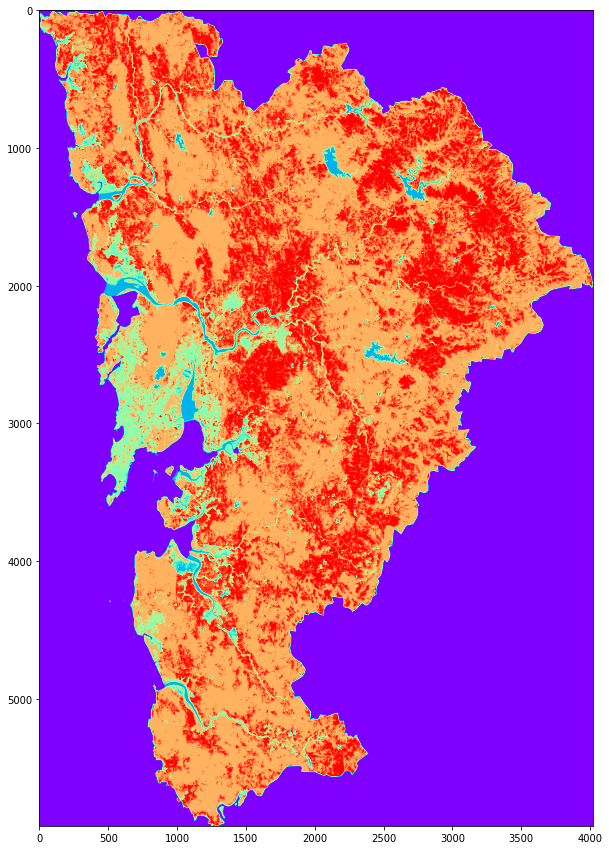

In [ ]:
#vis of classification output
plt.figure(figsize=(15, 15))
plt.imshow(classification_map_masked, cmap='rainbow')
plt.show()

In [ ]:
#saving data in geotiff format
classification_nn = np.zeros((1,nRows, nCols))
classification_nn[0] = classification_map_masked
meta = landsat.meta

In [ ]:
meta

{'count': 7,
 'crs': CRS.from_epsg(32643),
 'driver': 'GTiff',
 'dtype': 'uint16',
 'height': 5923,
 'nodata': 0.0,
 'transform': Affine(30.0, 0.0, 253950.0,
       0.0, -30.0, 2198250.0),
 'width': 4021}

In [ ]:
meta.update({'count': 1})

In [ ]:
# meta = {'count': 1,
#  'crs': rio.crs.CRS.from_epsg(32643),
#  'driver': 'GTiff',
#  'dtype': 'uint16',
#  'height': 5923,
#  'nodata': 0.0,
#  'transform': rio.transform.Affine(30.0, 0.0, 253950.0,
#        0.0, -30.0, 2198250.0),
#  'width': 4021}

In [ ]:
#writting geotiff file
with rio.open('classified_MLP_2000_Final_3.tif', 'w', **meta) as dst:
    dst.write(classification_nn)

In [ ]:
#check number of pixel in each class in GT array
classes = np.unique(GT_array)
print(classes)
for i in classes:
    print(len(np.where(GT_array.flatten() == i)[0]))

[0 1 2 3 4 5 6]
11567980
426240
530607
5362826
859294
1453399
3616037


In [ ]:
#check number of pixel in each class of classified image
classes = np.unique(classification_map_masked)
print(classes)
for i in range(20):
  if i in classes:
    print(len(np.where(classification_map_masked.flatten() == i)[0]))

[0 1 2 3 4]
11567980
374041
841130
6797953
4235279
